In [78]:
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patheffects import Stroke, Normal
import numpy as np
import toml
from datetime import datetime
import pandas as pd
import re
from typing import Union
import os
from matplotlib.colors import ListedColormap

In [79]:
URL_IMAGE = "./shots/leuven_geldenaaksepoort_20231017-114230.png"
LOCATION = "leuven"
STREET = "geldenaaksepoort"

image = Path(URL_IMAGE)
assert image.exists()

In [80]:
im = cv2.cvtColor(cv2.imread(image.as_posix()), cv2.COLOR_BGR2RGB)

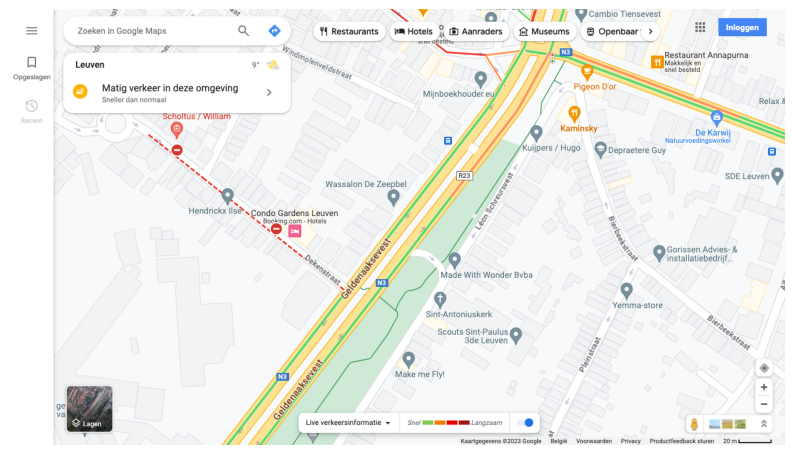

In [81]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_axis_off()
plt.imshow(im)

In [82]:
def display_shot(url: Union[str, os.PathLike]):
    if isinstance(url, str):
        image = Path(url)
    elif isinstance(url, os.PathLike):
        image = url
    else:
        raise TypeError("url must be a string or a path object")
    assert image.exists()
    im = cv2.cvtColor(cv2.imread(image.as_posix()), cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_axis_off()
    ax.imshow(im)
    return ax

In [83]:
# Open the TOML file
with open("config.toml", "r") as f:
    # Load the contents of the file into a dictionary
    config = toml.load(f)

# Print the values
print(config)

{'leuven': {'geldenaaksepoort': {'url': 'https://www.google.com/maps/@50.8726718,4.7131464,18z/data=!5m1!1e1', 'points': [[881, 89], [870, 108], [858, 131], [842, 158], [817, 193], [793, 225], [777, 247], [743, 290], [725, 314], [701, 346], [677, 375], [659, 400], [627, 440], [601, 475], [583, 499], [566, 520], [543, 550], [522, 577], [441, 684], [421, 708]]}}}


In [84]:
streets = list(config["leuven"].keys())
streets

['geldenaaksepoort']

In [86]:
number_of_points = len(config[LOCATION][STREET]["points"])

In [87]:
plt.rc("axes.spines", top=False, right=False)

In [88]:
URL_IMAGE_DIR = "shots"
url_image_dir = Path(URL_IMAGE_DIR)
assert url_image_dir.exists()
location = "leuven"

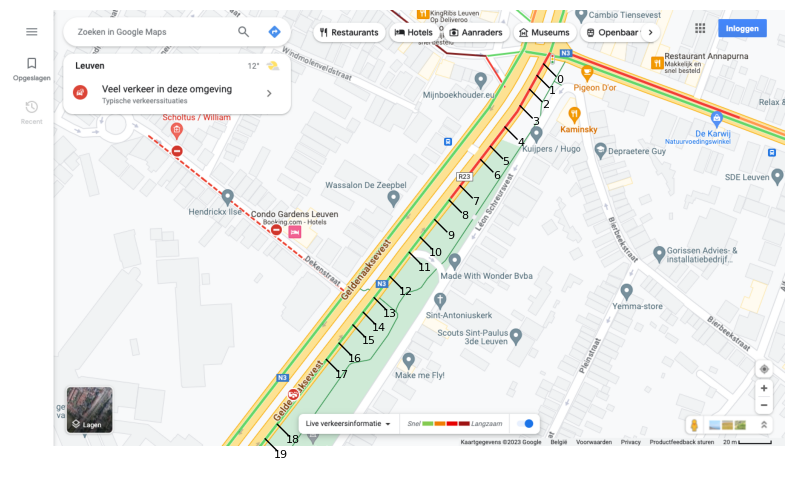

In [89]:
fig, ax = plt.subplots(figsize=(10, 10))

text_offset = 6
line_offset = 20

street_offsets = {
    "tiensestraat": [
        -line_offset,
        line_offset,
        -text_offset,
        text_offset,
        "center",
        "center",
    ],
    "tiensevest": [
        -line_offset,
        -line_offset,
        -text_offset,
        -text_offset,
        "center",
        "center",
    ],
    "geldenaaksepoort": [
        line_offset,
        line_offset,
        text_offset,
        text_offset,
        "center",
        "center",
    ],
    "tiensesteenweg": [
        line_offset,
        -line_offset,
        text_offset,
        -text_offset,
        "center",
        "center",
    ],
}

img_url_path = next(url_image_dir.glob(f"{location}_{STREET}_*.png"))
im = cv2.cvtColor(cv2.imread(img_url_path.as_posix()), cv2.COLOR_BGR2RGB)
ax.spines[:].set_visible(False)
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)
ax.imshow(im)
for i, p in enumerate(config[location][STREET]["points"]):
    x, y = p[0], p[1]
    x_end, y_end = x + street_offsets[STREET][0], y + street_offsets[STREET][1]
    ax.plot([x, x_end], [y, y_end], color="k", linewidth=1)
    ax.annotate(
        f"{i}",
        xy=(x_end, y_end),
        xytext=(x_end + street_offsets[STREET][2], y_end + street_offsets[STREET][3]),
        fontsize=8,
        ha=street_offsets[STREET][4],
        va=street_offsets[STREET][5],
    )
plt.savefig(
    f"meetpunten_leuven_{STREET}.png",  # Set path and filename
    dpi=300,  # Set dots per inch
    bbox_inches="tight",  # Remove extra whitespace around plot
    facecolor="white",
)  # Set background color to white

# Walk over screenshots and sample pixel colors

In [90]:
rows = []
for location in config.keys():
    for street in config[location].keys():
        for p in url_image_dir.glob(f"{location}_{street}_*.png"):
            # print (p.stem)
            timestamp = datetime.strptime(p.stem, f"{location}_{street}_%Y%m%d-%H%M%S")
            # if timestamp < datetime(2023, 10, 17, 15, 55, 0):
            #     # print(f"Skipped {p.stem}")
            #     continue
            screenshot = cv2.cvtColor(cv2.imread(p.as_posix()), cv2.COLOR_BGR2RGB)
            colors = ()
            if not "points" in config[location][street]:
                continue
            for point in config[location][street]["points"]:
                color = screenshot[point[1], point[0]]
                colors += (color, color[0], color[1], color[2])
            row = (location, street, p, timestamp) + colors
            rows.append(row)

In [91]:
# Initialize an empty list for the rows
rows = []

# Predefined color map with string representations of RGB values as keys
color_map = {
    "[129, 31, 31]": 0,  # darkred
    "[242, 60, 50]": 1,  # red
    "[255, 151, 77]": 2,  # orange
    "[99, 214, 104]": 3,  # green
    "[253, 226, 147]": 4  # peachpuff
}

# Reverse the color_map to map RGB tuples to indices
reversed_color_map = {tuple(map(int, key.strip('[]').split(', '))): value for key, value in color_map.items()}

for location in config.keys():
    for street in config[location].keys():
        for p in url_image_dir.glob(f"{location}_{street}_*.png"):
            timestamp = datetime.strptime(p.stem, f"{location}_{street}_%Y%m%d-%H%M%S")
            screenshot = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)

            if "points" not in config[location][street]:
                continue

            # Extract the color index for each point
            color_indices = []
            for point in config[location][street]["points"]:
                rgb_tuple = tuple(screenshot[point[1], point[0]])
                color_index = reversed_color_map.get(rgb_tuple, -1)  # Default to -1 if the color is not in the map
                color_indices.append(color_index)

            # Create a row with location, street, path, timestamp, and color indices
            row = [location, street, p.name, timestamp.isoformat()] + color_indices
            rows.append(row)

# Convert the list of rows to a NumPy array for indices
rows.sort(key=lambda row: datetime.fromisoformat(row[3]))
index_matrix = np.array(rows, dtype=object)

# Save the index matrix and the color map as text files
# np.savetxt('index_matrix.txt', index_matrix, fmt='%s')


In [92]:
# Sample data provided as strings, replace this with your actual data loading method
data_strings = index_matrix

# Parse the data into a structured format
timestamps = []
color_indices = []

for line in data_strings:
    parts = line
    #parts = line.split()
    # Parse the timestamp and convert to a datetime object
    timestamp = datetime.fromisoformat(parts[3])
    timestamps.append(timestamp)
    # Parse the color indices, which are all the parts after the timestamp
    indices = [int(idx) for idx in parts[4:]]
    color_indices.append(indices)

# Convert lists to NumPy arrays for plotting
timestamps = np.array(timestamps)
color_indices = np.array(color_indices)

# Assuming index_to_color is a dictionary mapping indices to color names
index_to_color = {0: 'darkred', 1: 'red', 2: 'orange', 3: 'green'}

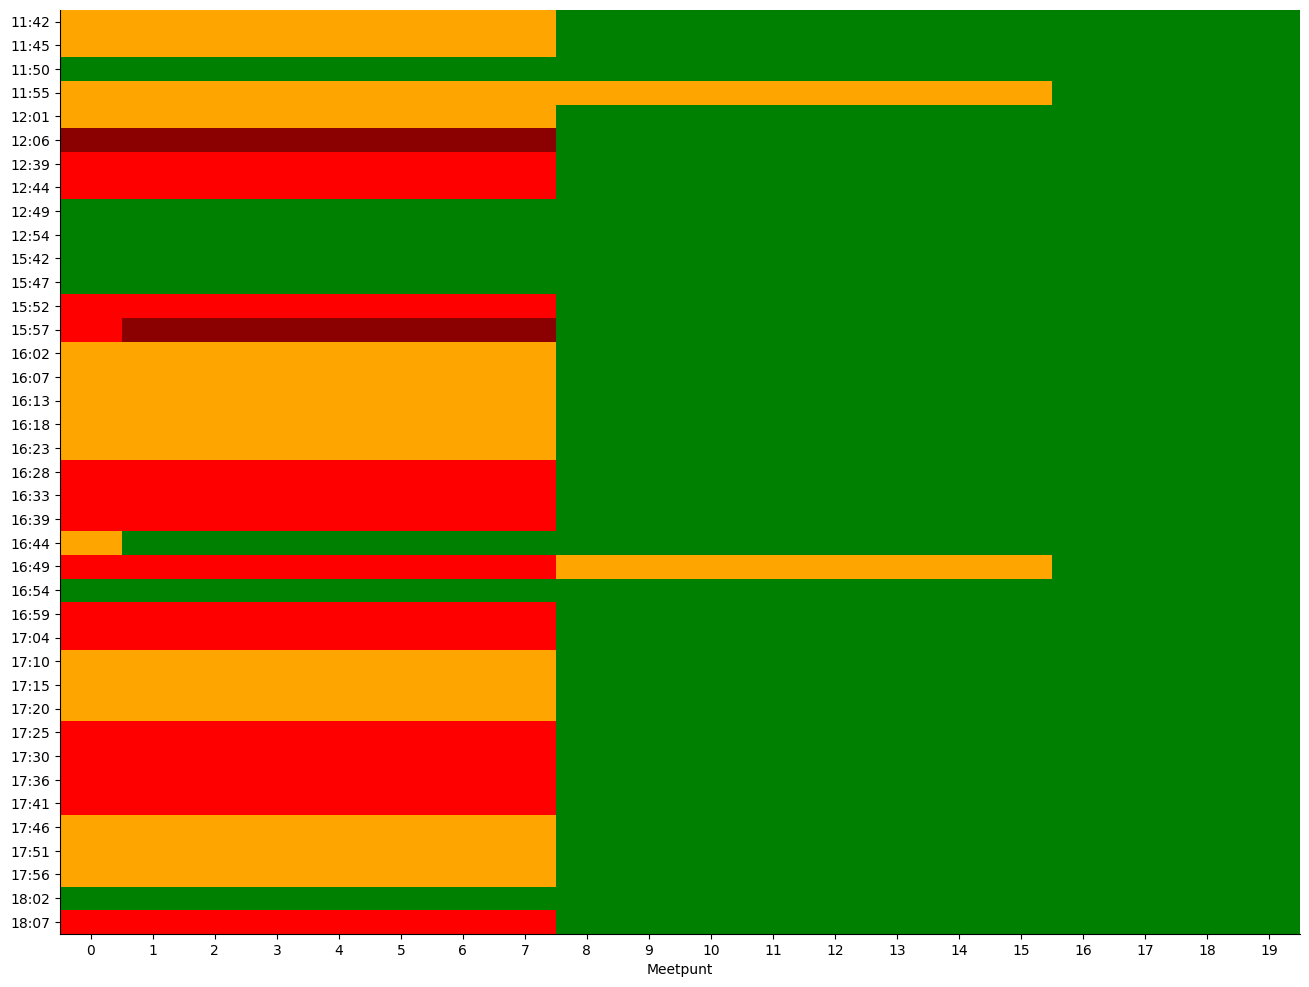

In [93]:
# Assuming 'index_matrix' is an array or list of lists with the provided format
# Extract the timestamps and convert them to a formatted string
timestamps = [datetime.fromisoformat(row[3]).strftime('%H:%M') for row in index_matrix]
color_indices = np.array([row[4:] for row in index_matrix], dtype=int)  # Color indices start from the 5th element

# Assuming 'index_to_color' is a dictionary where keys are integers and values are RGB tuples or color strings
sorted_indices = sorted(index_to_color.keys())
sorted_colors = [index_to_color[idx] for idx in sorted_indices]
cmap = ListedColormap(sorted_colors)

# Create a figure and axis for plotting the heatmap
fig, ax = plt.subplots(figsize=(16, 12))

# Plot the heatmap using the color indices and custom colormap
cax = ax.imshow(color_indices, cmap=cmap, aspect='auto')

# Format the x-axis to show each point index
ax.set_xlabel('Meetpunt')
ax.set_xticks(np.arange(len(color_indices[0])))
ax.set_xticklabels(range(len(color_indices[0])))

# Set the y-ticks and labels to the formatted timestamps
ax.set_yticks(np.arange(len(timestamps)))
ax.set_yticklabels(timestamps)

# Show the plot
plt.show()
